[Notebook of task](https://github.com/DistributedSystemsGroup/Algorithmic-Machine-Learning/blob/master/Challenges/Plankton/plankton_challenge.ipynb)

# Useful websites and articles
- [Data augmentation part 1](https://medium.com/nanonets/nanonets-how-to-use-deep-learning-when-you-have-limited-data-f68c0b512cab)
- [Data augmentation part 2](https://medium.com/nanonets/how-to-use-deep-learning-when-you-have-limited-data-part-2-data-augmentation-c26971dc8ced)

### Libraries for Deep NNs
Most relevant
- [TensorFlow](https://www.tensorflow.org/)
- [Keras](https://keras.io/)
- [Theano](http://deeplearning.net/software/theano/)

Less relevant (mostly for GPU optimisation)
- [Caffe](http://caffe.berkeleyvision.org/)
- [Neon](https://www.intel.ai/neon-2-0-optimized-for-intel-architectures/)


# Gjenstående oppgaver

- Generere mer data, for å gjevne ut dataset 
- Lage funksjon for å laste bilder inn i minne, uten å fylle det opp
- Teste ut forskjellige CNN arkitekturer
 - input -> (conv -> pool)*2 -> fc -> softmax
 - input -> (conv -> conv -> pool)*3-4 -> fc -> fc -> softmax
- Lage feature recognition model
- Data exploration

In [107]:
%matplotlib inline
# For configuration and jupiter
import os
import sys
import re
import random
import matplotlib
import implicit
import warnings
# For data manipulation
import pandas as pd
import numpy as np
# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
# For prediction
from tqdm import tqdm

# code inspired by https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/
import zipfile
from extract_zip import extract_zip_to_memory # function for decompressing zip in memory
from PIL import Image, ImageOps # image handling
from io import BytesIO # image handling

base = '/mnt/datasets/plankton/flowcam/'

# Nr of picture/rows = 243 611

In [108]:
image_filename = base + "imgs.zip"
imgFiles = extract_zip_to_memory(image_filename)

In [109]:
print(imgFiles['imgs/32738710.jpg'])

In [110]:
list(imgFiles.keys())[:5]

['imgs/32563660.jpg',
 'imgs/32735552.jpg',
 'imgs/32627324.jpg',
 'imgs/32675640.jpg',
 'imgs/32723573.jpg']

In [111]:
img_array = np.array(Image.open(imgFiles['imgs/32738710.jpg']))
print(img_array)

[[255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 ...
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]
 [255 255 255 ... 255 255 255]]


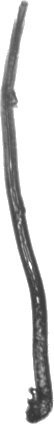

In [142]:
Image.open(imgFiles['imgs/32627324.jpg'])

In [113]:
nativeDF = pd.read_csv(base + 'features_native.csv.gz')
skimagDF = pd.read_csv(base + 'features_skimage.csv.gz')
labelsDF = pd.read_csv(base + 'meta.csv')

In [114]:
#print(nativeDF.isnull().sum().sort_values(ascending=False)[:10])
#print(skimagDF.isnull().sum().sort_values(ascending=False)[:6])

native_nan_cols = ['perimareaexc', 'feretareaexc', 'cdexc', 'skeleton_area',
                   'nb1_area', 'symetrieh_area', 'symetriev_area', 'convarea_area',
                  'nb2_area', 'nb3_area', ]
skimage_nan_cols = ['moments_normalized4', 'weighted_moments_normalized0', 
                    'moments_normalized1', 'moments_normalized0',
                   'weighted_moments_normalized1', 'weighted_moments_normalized4']

In [115]:
for col_name in native_nan_cols:
    nativeDF[col_name] = nativeDF[col_name].fillna(0)

for col_name in skimage_nan_cols:
    skimagDF[col_name] = skimagDF[col_name].fillna(0)

labelsDF['objid'] = labelsDF['objid'].astype(np.int64, errors='ignore')
labelsDF['level1'] = labelsDF['level1'].fillna('No level1 name')
labelsDF['level2'] = labelsDF['level2'].fillna('No level2 name')

print(nativeDF.isnull().sum().any())
print(skimagDF.isnull().sum().any())
print(labelsDF.isnull().sum().any())

False
False
False


In [116]:
print('Nr. of unique level1 names')
print(labelsDF['level1'].nunique())
print('Nr. of unique level2 names')
print(labelsDF['level2'].nunique())
print('Nr. of unique names')
print(labelsDF['unique_name'].nunique())

Nr. of unique level1 names
57
Nr. of unique level2 names
40
Nr. of unique names
103


In [117]:
number_unique_names = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names.sort_values(inplace=True, ascending=False)

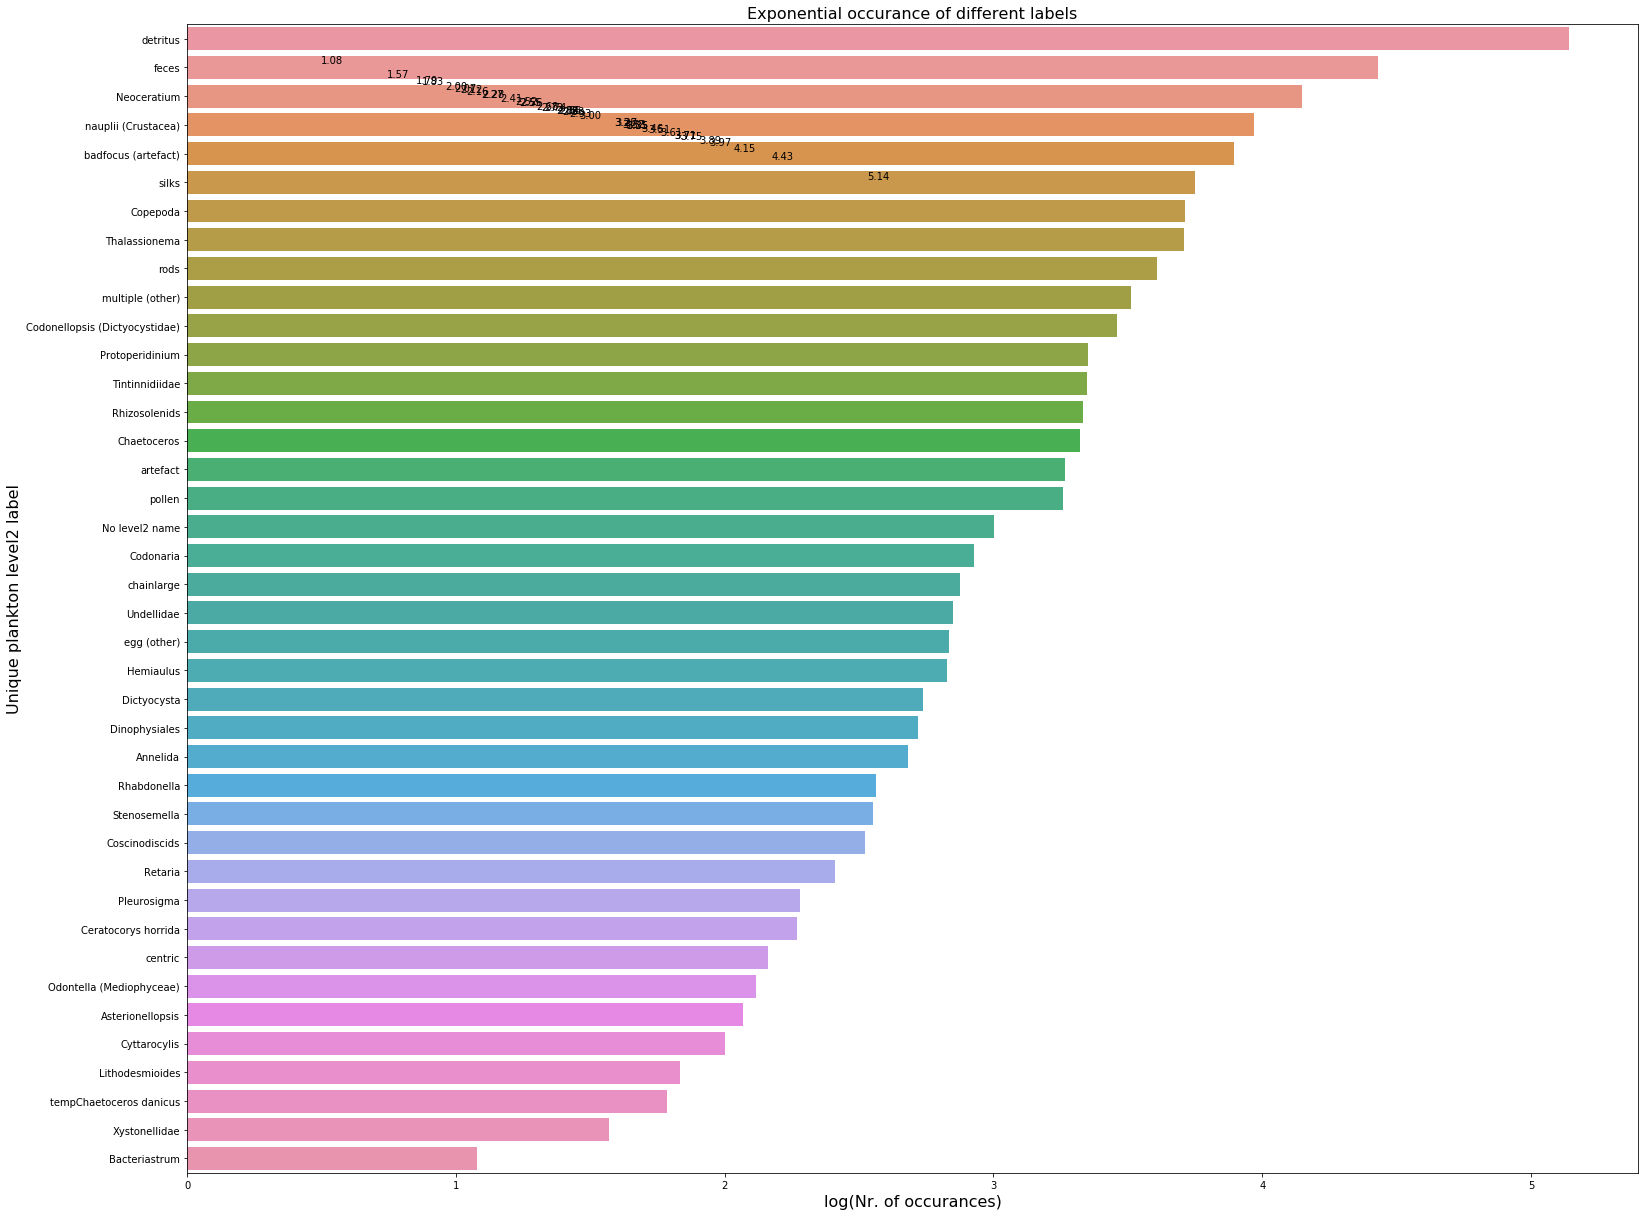

In [118]:
figure, ax = plt.subplots(figsize=(23,17))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))
# ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right")

'''for p in ax.patches:
    ax.annotate(format(p.get_height(), '.2f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')'''

for p in ax.patches:
    ax.annotate(format(p.get_width(),'.2f'), 
                (p.get_x() + p.get_width() / 2., p.get_width()),
                ha = 'center',
                va = 'center',
                xytext = (0, 10),
                textcoords = 'offset points')

plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=16)
plt.tight_layout()

In [130]:
# Fetching the object ids that pertain to specific labels
# And fetching the level2 labels of the categories we want to duplicate
unique_names = list(number_unique_names.index)
original_objid_dict = {}
labels_to_multiply = []

for name in unique_names:
    objid_labels = list(labelsDF.loc[labelsDF['level2'] == name, 'objid'])
    original_objid_dict.update({name : objid_labels})
    print('Label:', name[:4], 'has', len(objid_labels), 'object IDs.')
    # Find labels that we want to generate more data within
    if len(objid_labels) < 1000:
        labels_to_multiply.append(name)    


Label: detr has 138439 object IDs.
Label: fece has 26936 object IDs.
Label: Neoc has 14014 object IDs.
Label: naup has 9293 object IDs.
Label: badf has 7848 object IDs.
Label: silk has 5629 object IDs.
Label: Cope has 5141 object IDs.
Label: Thal has 5117 object IDs.
Label: rods has 4044 object IDs.
Label: mult has 3261 object IDs.
Label: Codo has 2888 object IDs.
Label: Prot has 2256 object IDs.
Label: Tint has 2227 object IDs.
Label: Rhiz has 2160 object IDs.
Label: Chae has 2105 object IDs.
Label: arte has 1849 object IDs.
Label: poll has 1821 object IDs.
Label: No l has 1003 object IDs.
Label: Codo has 845 object IDs.
Label: chai has 751 object IDs.
Label: Unde has 710 object IDs.
Label: egg  has 685 object IDs.
Label: Hemi has 670 object IDs.
Label: Dict has 549 object IDs.
Label: Dino has 525 object IDs.
Label: Anne has 481 object IDs.
Label: Rhab has 367 object IDs.
Label: Sten has 357 object IDs.
Label: Cosc has 334 object IDs.
Label: Reta has 257 object IDs.
Label: Pleu has 19

In [131]:
# Checking if all the object IDs start with the number 3
truthS = labelsDF['objid'].astype(str)
truth2 = truthS[:5]
flag = True
for items in truth2.iteritems():
    if (items[1][0] != '3'):
        flag = False
print(flag)

True


In [132]:
def strip(key):
    return int(key[5:-4])

def key_to_objid(list_of_keys):
    return [strip(key) for key in list_of_keys]

def reverse_strip(objid):
    return 'imgs/' + str(objid) + '.jpg'

def objid_to_key(list_of_objids):
    return [reverse_strip(objid) for objid in list_of_objids]

def generate_new_keys(key):
    stripped_key = str(strip(key))
    key_lr = reverse_strip('8' + stripped_key[1:])
    key_ud = reverse_strip('1' + stripped_key[1:])
    key_90 = reverse_strip('2' + stripped_key[1:])
    key_180 = reverse_strip('4' + stripped_key[1:])
    key_270 = reverse_strip('5' + stripped_key[1:])
    key_t1 = reverse_strip('6' + stripped_key[1:])
    key_t2 = reverse_strip('7' + stripped_key[1:])
    return {'lr' : key_lr, 'ud' : key_ud, '90' : key_90, '180' : key_180,
                '270' : key_270, 't1' : key_t1, 't2' : key_t2}

def generate_duplicates(key, image_files=imgFiles, label_DF=labelsDF):
    # Fetching and making numpy array of original object
    jpeg_img_object = Image.open(image_files[key])
    img_np_array = np.array(jpeg_img_object)
    
    # Generating copies of data using numpy functions for flipping, rotating and transposing
    img_flipped_ud = np.flip(img_np_array, 0)
    img_flipped_lr = np.flip(img_np_array, 1)
    img_rot_90 = np.rot90(img_np_array, k=1)
    img_rot_180 = np.rot90(img_np_array, k=2)
    img_rot_270 = np.rot90(img_np_array, k=3)
    img_tran_1 = np.transpose(img_np_array)
    img_tran_2 = np.flip(np.transpose(np.flip(img_np_array, 1)), 1)
    
    nrCopies = 7
    
    # Generating new keys
    key_dict = generate_new_keys(key) 
    # Updating dictionary of images with new data
    image_files.update({key_dict['ud'] : img_flipped_ud, key_dict['lr'] : img_flipped_lr, 
                      key_dict['90'] : img_rot_90, key_dict['180'] : img_rot_180, 
                      key_dict['270'] : img_rot_270, key_dict['t1'] : img_tran_1, 
                      key_dict['t2'] : img_tran_2})
    
    # Generating new labels
    truth_array = label_DF['objid'].isin([strip(key)])
    label_2_copy = label_DF[truth_array]
    copied_labels = label_2_copy
    for i in range(nrCopies - 1):
        copied_labels = copied_labels.append(label_2_copy, ignore_index=True)
    
    new_keys = list(key_dict.values())
    for i in range(nrCopies):
        copied_labels.at[i, 'objid'] = strip(new_keys[i])
    
    # Update label_DF
    label_DF = label_DF.append(copied_labels, ignore_index=True)
    return image_files, label_DF

# testkey = 'imgs/32606329.jpg'
# imgFiles, labelsDF = generate_duplicates(testkey)
# print(imgFiles[testkey])
# print(fetch_labels([testkey]))

In [134]:
# Actually generate more data
total_nr = 0
for label in labels_to_multiply:
    object_ids = original_objid_dict[label]
    print('For label:', label[:4], 'we generate', len(object_ids)*8, 'new images')
    total_nr += len(object_ids)*8
    for objid in object_ids:
        ImgFiles, labelsDF = generate_duplicates(reverse_strip(objid))
print('Total number produced:', total_nr)    

For label: Codo we generate 6760 new images
For label: chai we generate 6008 new images
For label: Unde we generate 5680 new images
For label: egg  we generate 5480 new images
For label: Hemi we generate 5360 new images
For label: Dict we generate 4392 new images
For label: Dino we generate 4200 new images
For label: Anne we generate 3848 new images
For label: Rhab we generate 2936 new images
For label: Sten we generate 2856 new images
For label: Cosc we generate 2672 new images
For label: Reta we generate 2056 new images
For label: Pleu we generate 1528 new images
For label: Cera we generate 1488 new images
For label: cent we generate 1160 new images
For label: Odon we generate 1048 new images
For label: Aste we generate 936 new images
For label: Cytt we generate 800 new images
For label: Lith we generate 544 new images
For label: temp we generate 488 new images
For label: Xyst we generate 296 new images
For label: Bact we generate 96 new images
Total number produced: 60632


Text(0.5,1,'Label distribution b/ aug')

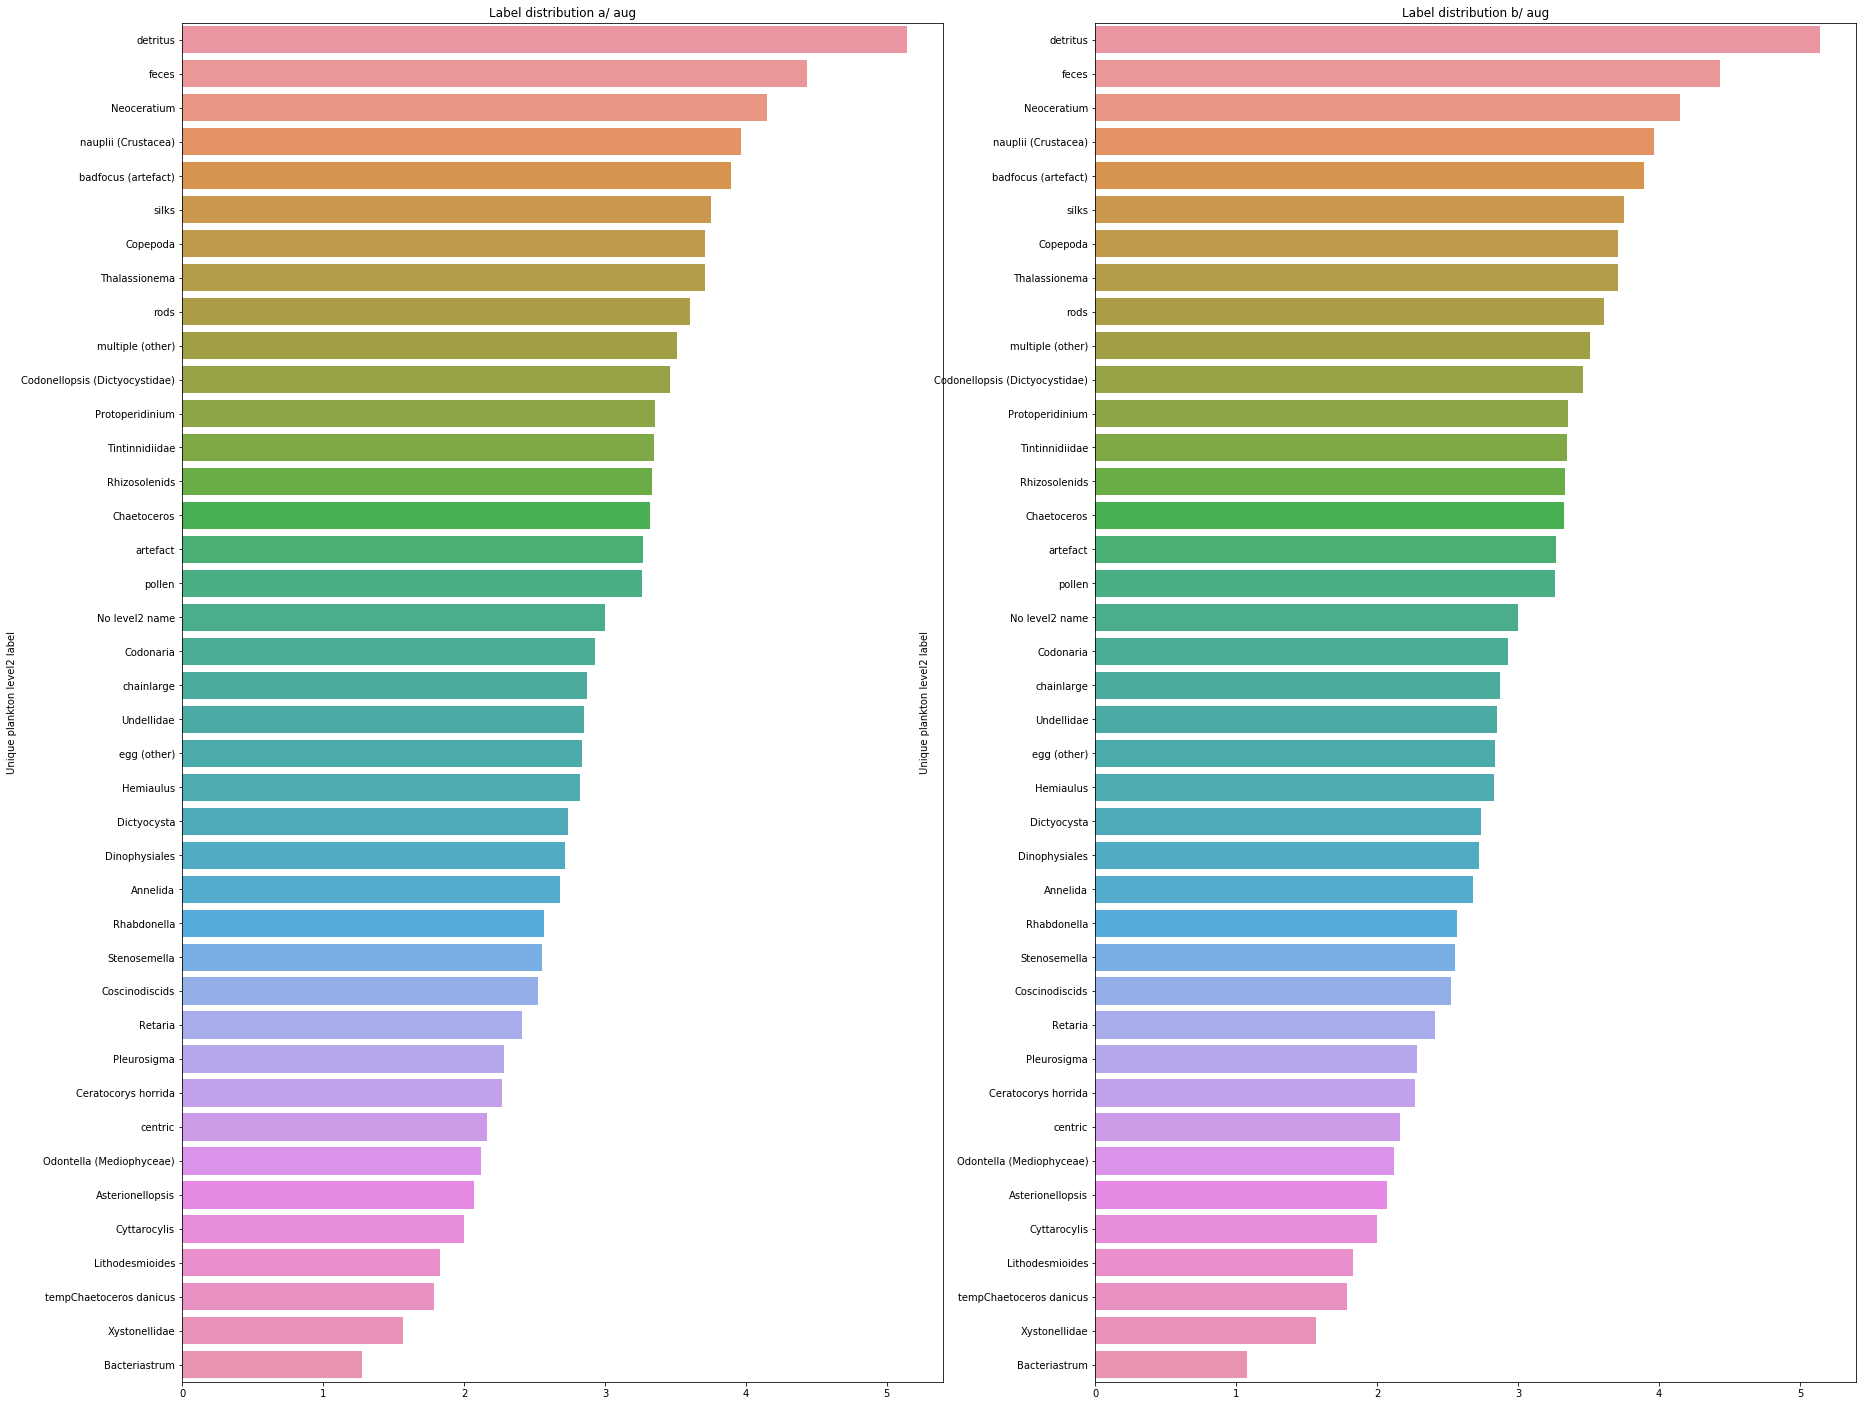

In [138]:
number_unique_names2 = labelsDF.groupby('level2', as_index=True)['id'].count()
number_unique_names2.sort_values(inplace=True, ascending=False)

'''figure, ax = plt.subplots(figsize=(23,17))
ax = sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values))
plt.ylabel('Unique plankton level2 label', fontsize= 16)
plt.xlabel('log(Nr. of occurances)', fontsize= 16)
plt.title('Exponential occurance of different labels', fontsize=16)
plt.tight_layout()'''
fig = plt.figure(figsize=(30,25))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

sns.barplot(y=number_unique_names2.index, x=np.log10(number_unique_names2.values), ax=ax1)
sns.barplot(y=number_unique_names.index, x=np.log10(number_unique_names.values), ax=ax2)

ax1.set_ylabel('Unique plankton level2 label')
ax1.set_title('log(Nr. of occurances)')
ax1.set_title('Label distribution a/ aug')

ax2.set_ylabel('Unique plankton level2 label')
ax2.set_title('log(Nr. of occurances)')
ax2.set_title('Label distribution b/ aug')

In [140]:
print('New number of images:', len(list(imgFiles.keys())))
print('Old number of images:', len(list(imgFiles.keys())) - total_nr)
print('Numbero labels in df:', labelsDF.shape[0])

New number of images: 296663
Old number of images: 236031
Numbero labels in df: 243617


In [ ]:
# Functions to fetch data for NN
def image_processing(key):
    desired_size = 972 # max of width and height in dataset
    if str(strip(key))[0] == '3':
        im_orginal = Image.open(imgFiles[key])
    else:
        im_orginal = Image.fromarray(imgFiles[key])
    old_size = im_orginal.size  # old_size[0] is in (width, height) format
    
    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])
    im_scaled = im_orginal.resize(new_size) # scale up picture before padding to keep information
    
    delta_w = desired_size - new_size[0]
    delta_h = desired_size - new_size[1]
    padding = (delta_w//2, delta_h//2, delta_w-(delta_w//2), delta_h-(delta_h//2))
    im_padded = ImageOps.expand(im_scaled, padding, fill=255) # padding of scaled picture
    
    final_size = (100, 100) # input size for CNN
    im_final = im_padded.resize(final_size, resample=0) # resize to input size of CNN
    return np.array(im_final)

def autoloader(list_of_keys):
    return np.array([image_processing(key) for key in list_of_keys])

def fetch_labels(list_of_keys, lvl='level2'):
    list_of_objid = key_to_objid(list_of_keys)
    labels = []
    for objid in list_of_objid:
        label = list(labelsDF[labelsDF['objid']==objid][lvl])
        labels.append(label[0])
    return labels

In [ ]:
img_files_keys = list(imgFiles.keys())

# Divide data into trainingand test data, by keys
from sklearn.model_selection import train_test_split
seed = 1
test_size = 0.10
keys_train, keys_test = train_test_split(img_files_keys, test_size = test_size, random_state = seed)

# Make small test and validation set, to explore models. 
size_small_train, size_small_validation = 50000, 9000
small_keys_train = keys_test[size_small_validation:(size_small_validation + size_small_train)]
small_keys_validation = keys_train[:size_small_validation]

In [ ]:
# We want to label-encode the different categories so we can one-hot encode them.  
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

# Fetch pictures and labels, corresponding to keys.
# train
X_train = autoloader(small_keys_train)
y_train = fetch_labels(small_keys_train)
# test
X_test = autoloader(small_keys_validation)
y_test = fetch_labels(small_keys_validation)

# label encode target column
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)

# one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape input data to account for images only being greyscale
X_train = X_train.reshape(size_small_train, 100, 100, 1)
X_test = X_test.reshape(size_small_validation, 100, 100, 1)

In [ ]:
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

In [ ]:
# Building the CNN
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten

# # Create model
model = Sequential()

# input -> conv(128) -> conv(32) -> flatten -> fc -> softmax
# Add model layers
model.add(Conv2D(128, kernel_size=3, activation='relu', input_shape=(100,100,1)))
model.add(Conv2D(32, kernel_size=3, activation='relu'))
model.add(Flatten())
model.add(Dense(40, activation='softmax'))

# # Compile model using accuracy to measure model performance
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)